In [2]:
import torch.nn as nn
import torch
import utils
import train
import numpy as np
import pickle5 as pickle

device = torch.device("cuda:0")
torch.cuda.is_available(), device

(True, device(type='cuda', index=0))

In [3]:
seeds = [0,1,2]
dataset = 'CIFAR10'
depth = 56
num_classes = 10
n_models = 8
confs = [25,23,21,18,16,12,8]
device_num_blocks = 6 * [27] 
for i in range(2):
    device_num_blocks += confs 
device_nums = [6] + 7*[2]

normal_base_paths = [f'saved_models/{dataset}/FedResNet{depth}_{i}/' for i in seeds]
adaptable_base_paths = [f'saved_models/{dataset}/FedAccordionResNet{depth}_{i}/' for i in seeds]
class_base_paths = [f'saved_models/{dataset}/FedClassResNet{depth}_{i}/' for i in seeds]
small_base_paths = [f'saved_models/{dataset}/FedSmallResNet{depth}_{i}/' for i in seeds]
distill_base_paths = [f'saved_models/{dataset}/FedDistillAccordionResNet{depth}_{i}/' for i in seeds]
distill1_base_paths = [f'saved_models/{dataset}/FedDistillAccordion_1ResNet{depth}_{i}/' for i in seeds]

def get_mean_test_accuracies(base_paths):
    
    accuracies = []

    for base_path in base_paths:
        with open(base_path + 'global_test_accuracies.pkl', 'rb') as f:
            acc = pickle.load(f)
            acc = np.mean(np.array(acc), axis = 1)
            accuracies.append(acc)
    
    return np.mean(accuracies, axis = 0)

normal_mean_test_accuracies = get_mean_test_accuracies(normal_base_paths)
adaptable_mean_test_accuracies = get_mean_test_accuracies(adaptable_base_paths)
small_mean_test_accuracies = get_mean_test_accuracies(small_base_paths)
distill1_mean_test_accuracies = get_mean_test_accuracies(distill1_base_paths)
distill_mean_test_accuracies = get_mean_test_accuracies(distill_base_paths)


In [4]:
class_test_accuracies = []

for base_path in class_base_paths:
    class_accuracies = []
    for i in range(n_models):
        with open(base_path + f'global_test_accuracies{i}.pkl', 'rb') as f:
            acc = pickle.load(f)
            acc = np.mean(acc, axis = 1)
            class_accuracies.append(acc)
    
    class_accuracies = np.average(class_accuracies, weights = device_nums, axis = 0)
    class_test_accuracies.append(class_accuracies)

class_mean_test_accuracies = np.mean(class_test_accuracies, axis = 0)

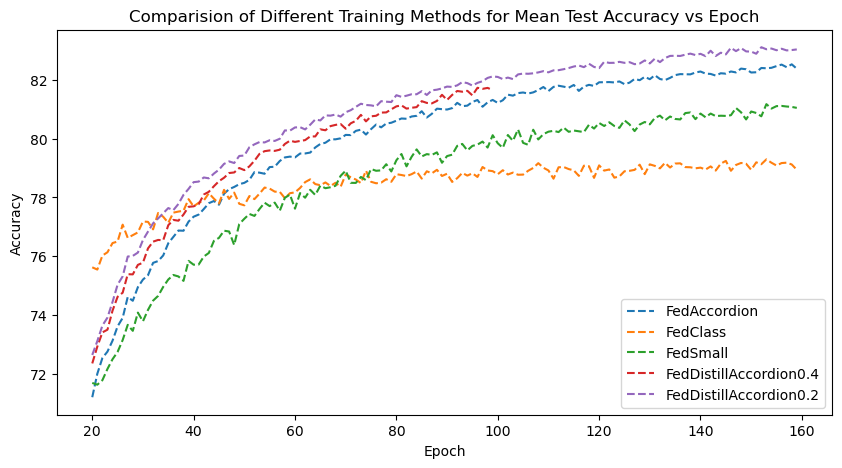

In [5]:
import matplotlib.pyplot as plt

tab = np.arange(len(normal_mean_test_accuracies))[20:]

plt.figure(figsize=(10,5))
#plt.plot(tab, normal_mean_test_accuracies[40:], linestyle = '--', label = 'Fed')
plt.plot(tab, adaptable_mean_test_accuracies[20:], linestyle =  '--',  label = 'FedAccordion')
plt.plot(tab, class_mean_test_accuracies[20:], linestyle = '--',  label = 'FedClass')
plt.plot(tab, small_mean_test_accuracies[20:], linestyle = '--',  label = 'FedSmall')
plt.plot(np.arange(len(distill1_mean_test_accuracies))[20:], distill1_mean_test_accuracies[20:], linestyle = '--', label = 'FedDistillAccordion0.4')
plt.plot(np.arange(len(distill_mean_test_accuracies))[20:], distill_mean_test_accuracies[20:], linestyle = '--', label = 'FedDistillAccordion0.2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Comparision of Different Training Methods for Mean Test Accuracy vs Epoch")

plt.legend()

# Calculate Normal Fed Energy per Epoch

In [24]:
import utils
import torch
import exp_utils

device = torch.device("cuda:5")
depth = 56
num_classes = 10

net_full = utils.get_model(depth, num_classes, device, dataset_name='CIFAR10')

model_size_mb = utils.get_model_size(net_full)

print(f"The full model is {model_size_mb:.3f} MBs")

Create ResNet-56 for CIFAR10
The full model is 3.270 MBs


In [25]:
comm_energy_per_bit = 1e-6
comm_energy_per_mbit = comm_energy_per_bit * 1e6

def get_model_size_mbit(net, num_blocks, model_size_mb):

    net.reconfigure_blocks(num_blocks)

    return net.model_fraction * model_size_mb * 8

def get_comm_energy_per_epoch(n_devices, model_size_mbit):

    return n_devices * 2 * model_size_mbit * comm_energy_per_mbit



In [26]:
model_size_mbit = get_model_size_mbit(net_full, 27, model_size_mb)
model_size_mbit

26.159423828125

In [27]:
n_devices = 20
comm_energy_per_epoch = get_comm_energy_per_epoch(n_devices, model_size_mbit)
comm_energy_per_epoch

1046.376953125

In [28]:
small_model_size_mbit = get_model_size_mbit(net_full, 8, model_size_mb)
small_model_size_mbit

1.1803692573246183

In [29]:
small_comm_energy_per_epoch = get_comm_energy_per_epoch(n_devices, small_model_size_mbit)
small_comm_energy_per_epoch

47.21477029298473

In [30]:
adaptable_model_sizes_mbit = [get_model_size_mbit(net_full, num_block, model_size_mb) for num_block in confs]

adaptable_comm_energy_per_epoch = 0
for i, msize in enumerate(adaptable_model_sizes_mbit):
    adaptable_comm_energy_per_epoch += get_comm_energy_per_epoch(device_nums[i], msize)

adaptable_comm_energy_per_epoch

440.148379967601

In [31]:
class_comm_energy_per_epoch = adaptable_comm_energy_per_epoch

[Text(0, 0, '1046.38'),
 Text(0, 0, '440.148'),
 Text(0, 0, '440.148'),
 Text(0, 0, '47.2148')]

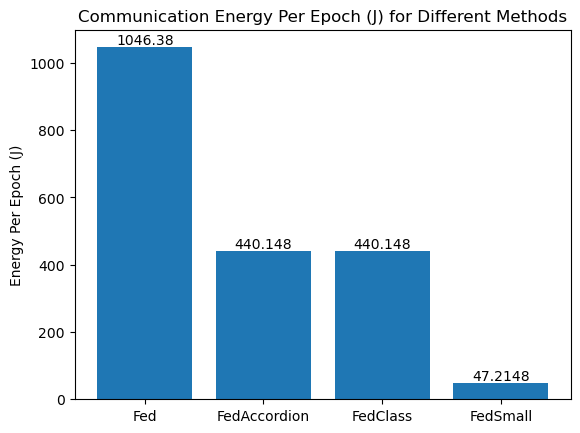

In [32]:
import matplotlib.pyplot as plt

method_names = ['Fed', 'FedAccordion', 'FedClass', 'FedSmall']
method_counts = [comm_energy_per_epoch, adaptable_comm_energy_per_epoch, class_comm_energy_per_epoch, small_comm_energy_per_epoch]

fig, ax = plt.subplots()
bar_container = ax.bar(method_names, method_counts)
ax.set(ylabel='Energy Per Epoch (J)', title='Communication Energy Per Epoch (J) for Different Methods')
ax.bar_label(bar_container)

In [33]:
net_full.reconfigure_blocks(net_full.max_blocks)

In [34]:
comp_energy_per_flops = 3.7 * 1e-12
comp_energy_per_macs = 2 * comp_energy_per_flops

block_inputs = 10*[(16,32,32)] + 9*[(32,16,16)] + 8*[(64,8,8)]
model_input = (3,32,32)

block_macs, fractional_macs = exp_utils.get_fractional_macs(net_full, model_input, block_inputs)


The model has 853018 parameters and full model is 127111818.0 Mac
Layer 0 block 0 has 4672 params and 4816896.0 Mac
Layer 0 block 1 has 4672 params and 4816896.0 Mac
Layer 0 block 2 has 4672 params and 4816896.0 Mac
Layer 0 block 3 has 4672 params and 4816896.0 Mac
Layer 0 block 4 has 4672 params and 4816896.0 Mac
Layer 0 block 5 has 4672 params and 4816896.0 Mac
Layer 0 block 6 has 4672 params and 4816896.0 Mac
Layer 0 block 7 has 4672 params and 4816896.0 Mac
Layer 0 block 8 has 4672 params and 4816896.0 Mac
Layer 1 block 0 has 13952 params and 3604480.0 Mac
Layer 1 block 1 has 18560 params and 4767744.0 Mac
Layer 1 block 2 has 18560 params and 4767744.0 Mac
Layer 1 block 3 has 18560 params and 4767744.0 Mac
Layer 1 block 4 has 18560 params and 4767744.0 Mac
Layer 1 block 5 has 18560 params and 4767744.0 Mac
Layer 1 block 6 has 18560 params and 4767744.0 Mac
Layer 1 block 7 has 18560 params and 4767744.0 Mac
Layer 1 block 8 has 18560 params and 4767744.0 Mac
Layer 2 block 0 has 55552

In [40]:
fractional_macs

[496266.0,
 5313162.0,
 10130058.0,
 14946954.0,
 19763850.0,
 24580746.0,
 29397642.0,
 34214538.0,
 39031434.0,
 43848330.0,
 47452810.0,
 52220554.0,
 56988298.0,
 61756042.0,
 66523786.0,
 71291530.0,
 76059274.0,
 80827018.0,
 85594762.0,
 89166474.0,
 93909642.0,
 98652810.0,
 103395978.0,
 108139146.0,
 112882314.0,
 117625482.0,
 122368650.0,
 127111818.0]

In [42]:
confs = [25,23,21,18,16,12,8]
device_num_blocks = 6 * [27] 
for i in range(2):
    device_num_blocks += confs 
device_nums = [6] + 7*[2]

block_probabilities = np.zeros(28)
for i in device_num_blocks:
    block_probabilities[i] += 0.05
block_probabilities

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0.1,
       0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0.1, 0. , 0.1, 0. , 0.1,
       0. , 0.3])

In [43]:
import numpy as np
average_acc_macs = np.average(fractional_macs, weights = block_probabilities)
full_model_macs = fractional_macs[-1]

In [44]:
def get_comp_energy_per_epoch(model_macs, comp_energy_per_macs, dataset_size):
    return 2 * comp_energy_per_macs * dataset_size * model_macs

dataset_size = 45000
full_model_energy_per_epoch = get_comp_energy_per_epoch(full_model_macs, comp_energy_per_macs, dataset_size)
accordion_energy_per_epoch= get_comp_energy_per_epoch(average_acc_macs, comp_energy_per_macs, dataset_size)

In [45]:
local_epochs = 10
fed_energy_per_epoch = local_epochs * get_comp_energy_per_epoch(full_model_macs, comp_energy_per_macs, dataset_size) 
fedaccordion_energy_per_epoch = local_epochs * get_comp_energy_per_epoch(average_acc_macs, comp_energy_per_macs, dataset_size) 
class_energy_per_epoch =  local_epochs * get_comp_energy_per_epoch(average_acc_macs, comp_energy_per_macs, dataset_size) 
small_energy_per_epoch = local_epochs * get_comp_energy_per_epoch(fractional_macs[8], comp_energy_per_macs, dataset_size) 

[Text(0, 0, '846.565'),
 Text(0, 0, '641.642'),
 Text(0, 0, '641.642'),
 Text(0, 0, '259.949')]

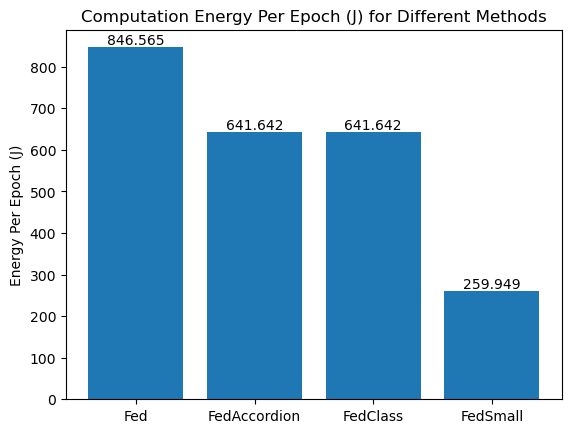

In [46]:
import matplotlib.pyplot as plt

method_names = ['Fed', 'FedAccordion', 'FedClass', 'FedSmall']
method_counts = [fed_energy_per_epoch, fedaccordion_energy_per_epoch, class_energy_per_epoch, small_energy_per_epoch]

fig, ax = plt.subplots()
bar_container = ax.bar(method_names, method_counts)
ax.set(ylabel='Energy Per Epoch (J)', title='Computation Energy Per Epoch (J) for Different Methods')
ax.bar_label(bar_container)

[1892.941661   1081.79053553 1081.79053553  307.16412073]


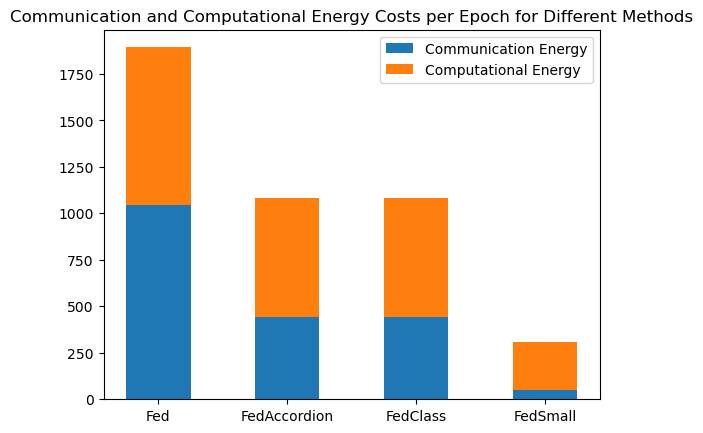

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

method_names = ['Fed', 'FedAccordion', 'FedClass', 'FedSmall']

weight_counts = {
    "Communication Energy": np.array([comm_energy_per_epoch, adaptable_comm_energy_per_epoch, class_comm_energy_per_epoch, small_comm_energy_per_epoch]),
    "Computational Energy": np.array(method_counts),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(4)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(method_names, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

print(bottom)
ax.set_title("Communication and Computational Energy Costs per Epoch for Different Methods")
ax.legend(loc="upper right")

plt.show()